## Description

This is a notebook with a simplified setup, which should show pure DS & CT speculation behaviour over an external stETH timeseries



```bash
python generate-events.py \
  --start-date 2024-01-01 \
  --end-date 2024-10-26 \
  --threshold 0.001 \
  --output events.json \
  --token-symbol stETH \
  --coin-gecko-id staked-ether \
  --vs-currency eth
```

In [11]:
# Install required packages if not already installed
# Uncomment the lines below if you need to install the packages

# !pip install pandas matplotlib seaborn colorama numpy requests 

# Import standard libraries
import random
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import widgets for interactivity
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

# Import custom modules
from agents.insurer import Insurer
from agents.lst_maximalist import LstMaximalist
from agents.ct_long_term import CTLongTermAgent
from agents.ct_speculation import CTShortTermAgent
from agents.ds_long_term import DSLongTermAgent
from agents.ds_speculation import DSShortTermAgent
from agents.redemption_arbitrage import RedemptionArbitrageAgent
from agents.repurchase_arbitrage import RepurchaseArbitrageAgent
from agents.lv_depositor import LVDepositorAgent
from agents.looping import LoopingAgent
from simulator.blockchain import Blockchain
from simulator.amm import UniswapV2AMM, YieldSpaceAMM

# Set plotting style
sns.set_style('whitegrid')

# Enable inline plotting for Jupyter
%matplotlib inline

### Defining Configuration Parameters

In this section, we'll define the simulation parameters. You can adjust these parameters to see how they affect the simulation.


In [12]:
# Simulation parameters
NUM_BLOCKS = 300  # Number of blocks to simulate
INITIAL_ETH_BALANCE = 100.0  # Initial ETH balance for each agent
PSM_EXPIRY_AFTER_BLOCK = 300  # Block after which the Peg Stability Module (PSM) expires

# Token parameters
TOKEN_NAME = 'stETH'  # Name of the token to simulate
INITIAL_AGENT_TOKEN_BALANCE = 100.0  # Initial token balance for each agent
AMM_RESERVE_ETH = 1000000.0  # Initial ETH reserve in the AMM
AMM_RESERVE_TOKEN = 1000000.0  # Initial token reserve in the AMM
AMM_FEE = 0.00  # Fee percentage in the AMM
INITIAL_YIELD_PER_BLOCK = 0.03 / 365  # Yield per block (assuming 3% annual yield)
PSM_REDEMPTION_FEES = 0.001  # Redemption fees for the Peg Stability Module
PSM_REPURCHASE_FEES = 0.05  # Reurchase fees for the Peg Stability Module

# Agents to include in the simulation
AGENT_NAMES = [
    #'LstMaximalist',
    #'Insurer',
    'DSShortTerm',
    'CTShortTerm',
    #'DSLongTerm',
    #'CTLongTerm',
    #'RedemptionArbitrage',
    #'RepurchaseArbitrage',
    #'LVDepositor',
    #'LoopingAgent'
    ]

## Initializing the Blockchain

Now we'll create the blockchain instance using the parameters defined above.


In [13]:
# Create the blockchain
chain = Blockchain(
    num_blocks=NUM_BLOCKS,
    initial_eth_balance=INITIAL_ETH_BALANCE,
    psm_expiry_after_block=PSM_EXPIRY_AFTER_BLOCK
)

## Adding Tokens and Agents

### Adding the Token

We'll add a token to the blockchain with its associated AMM.


In [14]:
# Add the token with the specified AMM
chain.add_token(
    token=TOKEN_NAME,
    risk=0.02,
    initial_agent_balance=INITIAL_AGENT_TOKEN_BALANCE,
    amm=UniswapV2AMM(
        token_symbol=TOKEN_NAME,
        reserve_eth=AMM_RESERVE_ETH,
        reserve_token=AMM_RESERVE_TOKEN,
        fee=AMM_FEE
    ),
    initial_yield_per_block=INITIAL_YIELD_PER_BLOCK
)

### Adding Agents

We'll instantiate the agents and add them to the blockchain.


In [15]:
# Instantiate agents based on AGENT_NAMES
agents = []
for name in AGENT_NAMES:
    #if name == 'LstMaximalist':
    #    agents.append(LstMaximalist(TOKEN_NAME))
    #elif name == 'Insurer':
    #    agents.append(Insurer(TOKEN_NAME))
    if name == 'DSShortTerm':
        agents.append(DSShortTermAgent(name="DS Short Term", token_symbol=TOKEN_NAME, threshold=0.01))
    elif name == 'CTShortTerm':
        agents.append(CTShortTermAgent(name="CT Short Term", token_symbol=TOKEN_NAME, buying_pressure=10))
    elif name == 'DSLongTerm':  
        agents.append(DSLongTermAgent(name="DS Long Term", token_symbol=TOKEN_NAME, buying_pressure=1))
    elif name == 'CTLongTerm':
        agents.append(CTLongTermAgent(name="CT Long Term", token_symbol=TOKEN_NAME, percentage_threshold=0.01))
    elif name == 'RedemptionArbitrage':
        agents.append(RedemptionArbitrageAgent(name="Redemption Arb", token_symbol=TOKEN_NAME))
    elif name == 'RepurchaseArbitrage':
        agents.append(RepurchaseArbitrageAgent(name="Repurchase Arb", token_symbol=TOKEN_NAME))
    elif name == 'LVDepositor':
        agents.append(LVDepositorAgent(name="LV Depositor", token_symbol=TOKEN_NAME, expected_apy=0.05))
    elif name == 'LoopingAgent':
        agents.append(LoopingAgent(
            name="Looping Agent", 
            token_symbol=TOKEN_NAME,
            initial_borrow_rate=0.001, 
            borrow_rate_changes={}, 
            max_ltv=0.7, 
            lltv=0.915))

# Add agents to the blockchain
chain.add_agents(*agents)


## Running the Simulation

Now we'll start the mining process, which runs the simulation over the specified number of blocks.


In [16]:
# Start mining without printing stats to minimize output
chain.start_mining(print_stats=False)

## Analyzing Results

After the simulation, we can analyze the collected statistics and visualize them using charts.


In [17]:
# Access stats dataframes
agents_stats = chain.stats['agents']
tokens_stats = chain.stats['tokens']
vaults_stats = chain.stats['vaults']
amms_stats = chain.stats['amms']
borrowed_eth_stats = chain.stats['borrowed_eth']
borrowed_tokens_stats = chain.stats['borrowed_tokens']


### Agent Wallet Face Value Over Time

Let's visualize how the wallet face value of each agent changes over time.


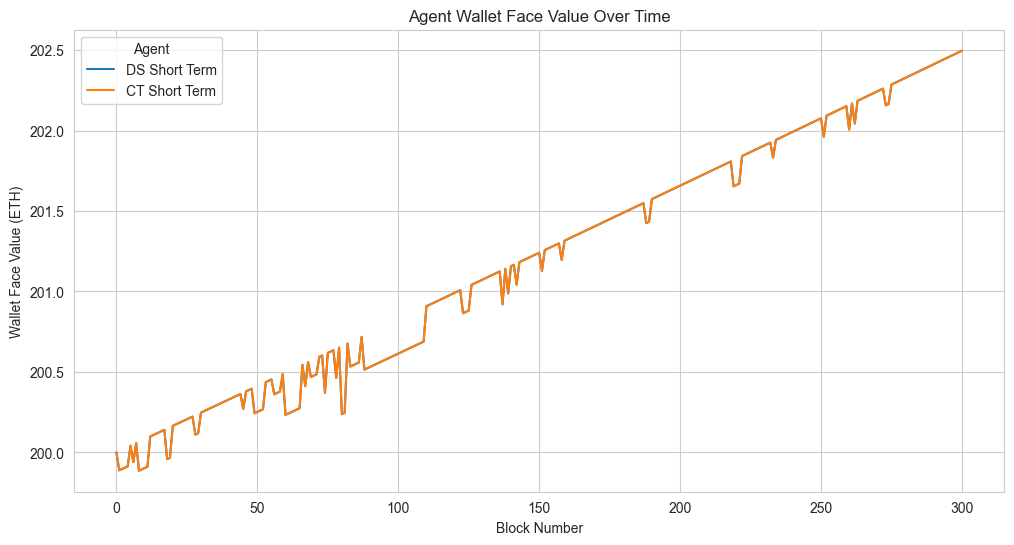

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=agents_stats,
    x='block',
    y='wallet_face_value',
    hue='agent',
)
plt.title('Agent Wallet Face Value Over Time')
plt.xlabel('Block Number')
plt.ylabel('Wallet Face Value (ETH)')
plt.legend(title='Agent')
plt.grid(True)
plt.show()

# Single Agent Walkthroughs

Let's validate all agents take action according to the triggers and reasoning specified

In [19]:
all_trades = pd.DataFrame(chain.all_trades)

In [20]:
(
    all_trades
    .groupby(['agent', 'action'])
    .agg(
        Total_Actions=('action', 'count'),
        Total_Volume_in_ETH=('volume', 'sum')
)
)

,,Total_Actions,Total_Volume_in_ETH
agent,action,,
CT Short Term,sell,22,0.000000
DS Short Term,buy,22,1981.077343


We can see that both Agents take some actions (with differing volumes). Let's investigate in more detail on a per agent level.

## DS Short

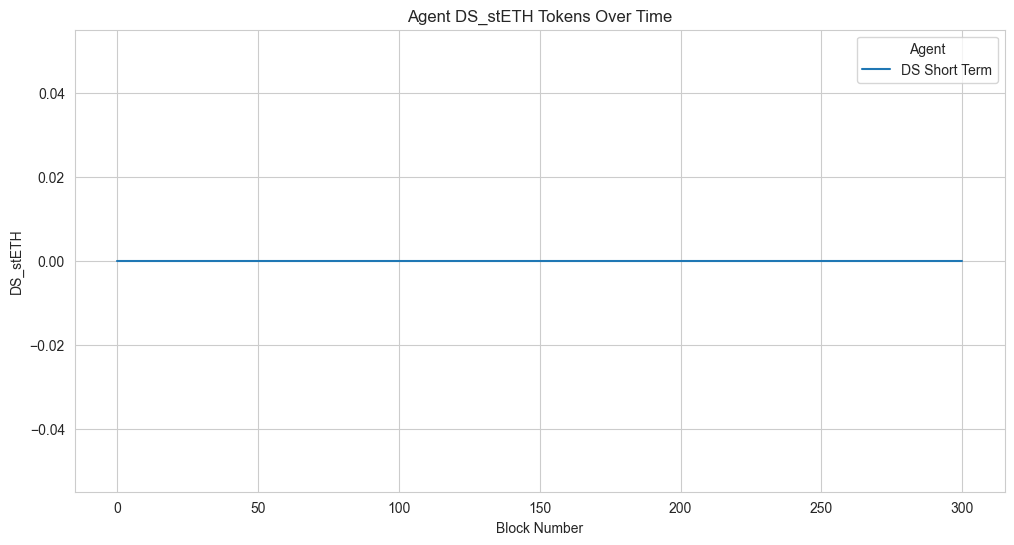

In [21]:
agents = ['DS Short Term']


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pd.concat([
        agents_stats.query("agent in @agents")[["agent","block"]],
        agents_stats.query("agent in @agents")["wallet_token_balances"].apply(pd.Series)
    ], axis=1),
    x='block',
    y='DS_stETH',
    hue='agent',
)
plt.title('Agent DS_stETH Tokens Over Time')
plt.xlabel('Block Number')
plt.ylabel('DS_stETH')
plt.legend(title='Agent')
plt.grid(True)
plt.show()

In [24]:
agents_stats.query("agent in @agents")["wallet_token_balances"].apply(pd.Series)

,stETH,CT_stETH,DS_stETH
0,100.000000,0.0,0.0
3,100.008219,0.0,0.0
5,100.016439,0.0,0.0
7,100.024660,0.0,0.0
9,100.032881,0.0,0.0
...,...,...,...
593,102.462610,0.0,0.0
595,102.471032,0.0,0.0
597,102.479454,0.0,0.0
599,102.487877,0.0,0.0


In [23]:
current_agent = "DS Short Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
)

,block,agent,token,volume,action,reason,arp,ewa_slope,arp_history
0,279,DS Short Term,DS,51.156020,buy,sharp decline,-0.248070,-0.010231,"[0.004657534246575341, 0.004590644614468318, 0..."
3,280,DS Short Term,DS,55.701959,buy,sharp decline,-0.261057,-0.011140,"[0.004657534246575341, 0.004590644614468318, 0..."
5,281,DS Short Term,DS,60.886020,buy,sharp decline,-0.275342,-0.012177,"[0.004657534246575341, 0.004590644614468318, 0..."
6,282,DS Short Term,DS,66.834280,buy,sharp decline,-0.291132,-0.013367,"[0.004657534246575341, 0.004590644614468318, 0..."
9,283,DS Short Term,DS,73.705776,buy,sharp decline,-0.308676,-0.014741,"[0.004657534246575341, 0.004590644614468318, 0..."
11,284,DS Short Term,DS,81.703479,buy,sharp decline,-0.328284,-0.016341,"[0.004657534246575341, 0.004590644614468318, 0..."
12,285,DS Short Term,DS,91.089809,buy,sharp decline,-0.350342,-0.018218,"[0.004657534246575341, 0.004590644614468318, 0..."
14,286,DS Short Term,DS,100.000000,buy,sharp decline,-0.375342,-0.020442,"[0.004657534246575341, 0.004590644614468318, 0..."
16,287,DS Short Term,DS,100.000000,buy,sharp decline,-0.403914,-0.023104,"[0.004657534246575341, 0.004590644614468318, 0..."
19,288,DS Short Term,DS,100.000000,buy,sharp decline,-0.436881,-0.026329,"[0.004657534246575341, 0.004590644614468318, 0..."


## DS Long Term

In [29]:
current_agent = "DS Long Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
)

,block,agent,token,volume,action,reason,buying_intent,ds_price,lst_yield_per_block,lst_price,depeg_threshold,extended_depeg_increase
0,1,DS Long Term,DS,1.561252e-07,buy,buying_intent,1.561252e-09,0.1,0.024658,NaN,NaN,NaN
2,2,DS Long Term,DS,1.561253e-07,buy,buying_intent,1.561253e-09,0.1,0.024658,NaN,NaN,NaN
4,3,DS Long Term,DS,1.561253e-07,buy,buying_intent,1.561253e-09,0.1,0.024658,NaN,NaN,NaN
6,4,DS Long Term,DS,1.888756e+01,buy,buying_intent,1.888756e-01,0.1,0.300000,NaN,NaN,NaN
8,5,DS Long Term,DS,1.532016e+01,buy,buying_intent,1.888757e-01,0.1,0.300000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
551,296,DS Long Term,DS,1.191572e-12,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN
552,297,DS Long Term,DS,5.079025e-13,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN
563,298,DS Long Term,DS,2.164913e-13,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN
568,299,DS Long Term,DS,9.227848e-14,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN


## CT Short Term

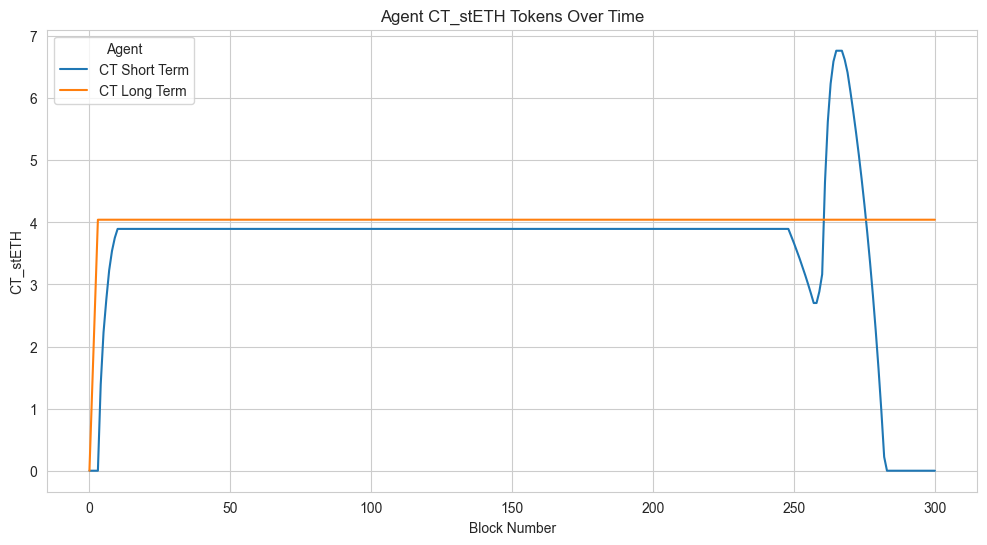

In [30]:
agents = ['CT Long Term', 'CT Short Term']


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pd.concat([
        agents_stats.query("agent in @agents")[["agent","block"]],
        agents_stats.query("agent in @agents")["wallet_token_balances"].apply(pd.Series)
    ], axis=1),
    x='block',
    y='CT_stETH',
    hue='agent',
)
plt.title('Agent CT_stETH Tokens Over Time')
plt.xlabel('Block Number')
plt.ylabel('CT_stETH')
plt.legend(title='Agent')
plt.grid(True)
plt.show()

In [32]:
current_agent = "CT Short Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,arp,ewa_slope,arp_history
7,4,CT Short Term,CT,1.253899,buy,sharp INcline,0.198990,0.125390,"[-0.07534246422198275, -0.07567691084083225, -..."
9,5,CT Short Term,CT,0.757527,buy,sharp INcline,0.198649,0.075753,"[-0.07534246422198275, -0.07567691084083225, -..."
10,6,CT Short Term,CT,0.483118,buy,sharp INcline,0.198305,0.048312,"[-0.07534246422198275, -0.07567691084083225, -..."
12,7,CT Short Term,CT,0.419682,buy,sharp INcline,0.227959,0.041968,"[-0.07534246422198275, -0.07567691084083225, -..."
15,8,CT Short Term,CT,0.281339,buy,sharp INcline,0.227611,0.028134,"[-0.07534246422198275, -0.07567691084083225, -..."
17,9,CT Short Term,CT,0.190658,buy,sharp INcline,0.227260,0.019066,"[-0.07534246422198275, -0.07567691084083225, -..."
19,10,CT Short Term,CT,0.129952,buy,sharp INcline,0.226907,0.012995,"[-0.07534246422198275, -0.07567691084083225, -..."
258,249,CT Short Term,CT,0.125425,sell,sharp DEcline,-0.246923,-0.010159,"[-0.07534246422198275, -0.07567691084083225, -..."
261,250,CT Short Term,CT,0.130182,sell,sharp DEcline,-0.258235,-0.010544,"[-0.07534246422198275, -0.07567691084083225, -..."
265,251,CT Short Term,CT,0.135214,sell,sharp DEcline,-0.270000,-0.010952,"[-0.07534246422198275, -0.07567691084083225, -..."


## CT Long Term

In [33]:
current_agent = "CT Long Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,arp,self.percentage_threshold
1,1,CT Long Term,CT,1.21656,buy,arp > self.percentage_threshold,0.075342,0.01
3,2,CT Long Term,CT,1.21656,buy,arp > self.percentage_threshold,0.075342,0.01
5,3,CT Long Term,CT,1.21656,buy,arp > self.percentage_threshold,0.075342,0.01


## Redemption Arbitrage

In [35]:
current_agent = "Redemption Arb"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,lst_price_in_eth,ds_price
270,252,Redemption Arb,DS,5.499995,buy,lst_price_in_eth + ds_price < 1,0.857375,0.1
271,252,Redemption Arb,LST,47.155625,buy,Match DS buy,0.857375,0.1
272,252,Redemption Arb,ETH,53.201482,redeem,Immediate Redeem after purchase,0.857375,0.1
278,253,Redemption Arb,DS,6.099993,buy,lst_price_in_eth + ds_price < 1,0.814515,0.1
279,253,Redemption Arb,LST,49.685387,buy,Match DS buy,0.814515,0.1
280,253,Redemption Arb,ETH,59.006928,redeem,Immediate Redeem after purchase,0.814515,0.1
283,254,Redemption Arb,DS,6.999991,buy,lst_price_in_eth + ds_price < 1,0.773797,0.1
284,254,Redemption Arb,LST,54.165814,buy,Match DS buy,0.773797,0.1
285,254,Redemption Arb,ETH,67.710690,redeem,Immediate Redeem after purchase,0.773797,0.1
290,255,Redemption Arb,DS,8.199988,buy,lst_price_in_eth + ds_price < 1,0.735117,0.1


## Repurchase Arbitrage

In [36]:
current_agent = "Repurchase Arb"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,lst_price_in_eth,ds_price
304,257,Repurchase Arb,LST,116.183357,Repurchase from PSM,lst_price_in_eth + ds_price > 1,1.000000,0.1
305,257,Repurchase Arb,DS,116.183357,Repurchase from PSM,lst_price_in_eth + ds_price > 1,1.000000,0.1
306,257,Repurchase Arb,DS,11.618313,sell,Immediate Sell at Market after Repurchase,1.000000,0.1
307,257,Repurchase Arb,LST,116.183357,sell,Immediate Sell at Market after Repurchase,1.000000,0.1
311,258,Repurchase Arb,LST,264.212216,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999977,0.1
312,258,Repurchase Arb,DS,264.212216,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999977,0.1
313,258,Repurchase Arb,DS,26.421166,sell,Immediate Sell at Market after Repurchase,0.999977,0.1
314,258,Repurchase Arb,LST,264.206077,sell,Immediate Sell at Market after Repurchase,0.999977,0.1
318,259,Repurchase Arb,LST,600.756386,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999924,0.1
319,259,Repurchase Arb,DS,600.756386,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999924,0.1


## LV depositor

In [37]:
current_agent = "LV depositor"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,additional_info


## Looping Agent

In [16]:
current_agent = "LoopingAgent"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,additional_info


### Token Prices Over Time

Visualize how the token price changes over time.


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=tokens_stats,
    x='block',
    y='price',
    hue='token',
    marker='o'
)
plt.title('Token Prices Over Time')
plt.xlabel('Block Number')
plt.ylabel('Price in ETH')
plt.legend(title='Token')
plt.grid(True)
plt.show()


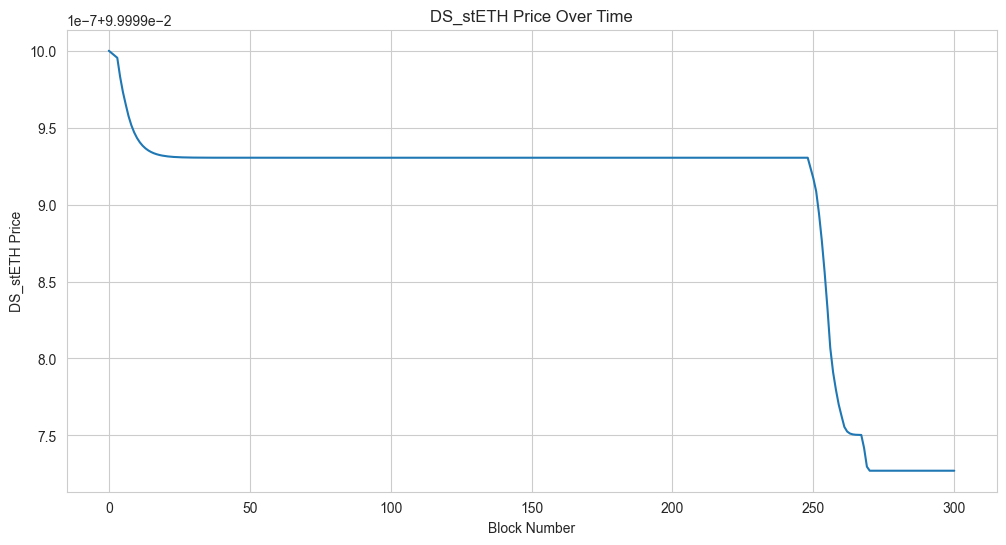

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=tokens_stats.query("token == 'DS_stETH'"),
    x='block',
    y='price'
    )
plt.title('DS_stETH Price Over Time')
plt.xlabel('Block Number')
plt.ylabel('DS_stETH Price')
plt.grid(True)
plt.show()

### AMM Reserves Over Time

#### Total ETH Reserve in AMMs


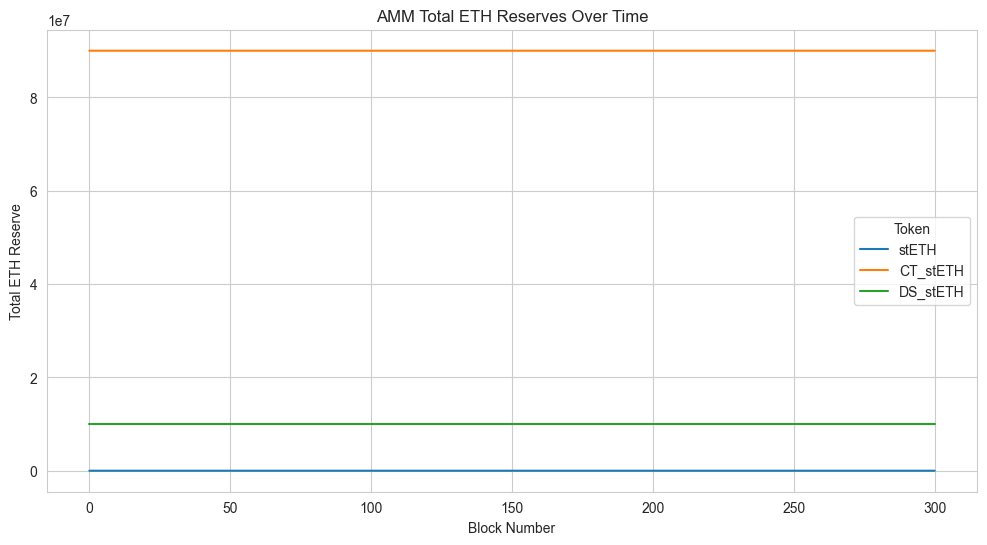

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=amms_stats,
    x='block',
    y='total_eth_reserve',
    hue='token',
)
plt.title('AMM Total ETH Reserves Over Time')
plt.xlabel('Block Number')
plt.ylabel('Total ETH Reserve')
plt.legend(title='Token')
plt.grid(True)
plt.show()


#### Total Token Reserve in AMMs


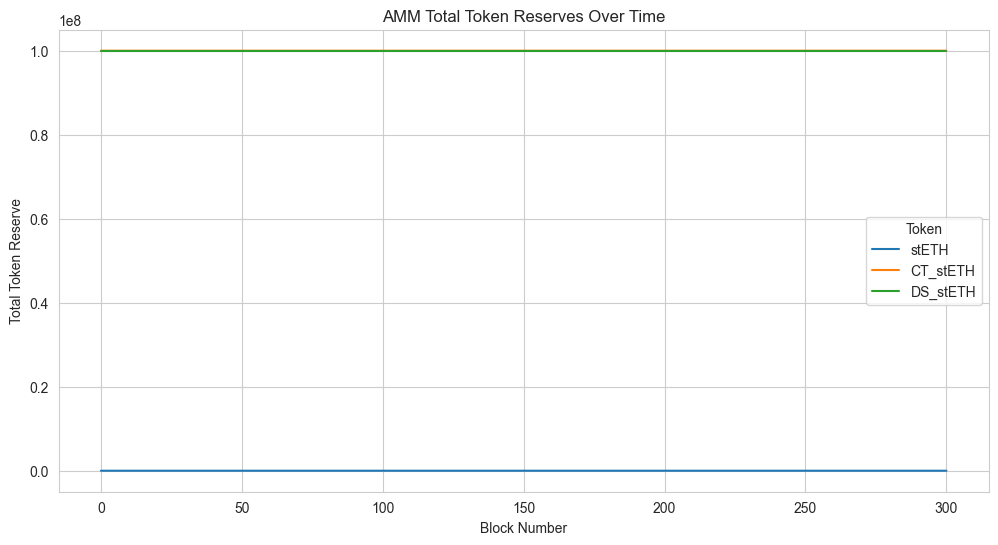

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=amms_stats,
    x='block',
    y='total_token_reserve',
    hue='token',
)
plt.title('AMM Total Token Reserves Over Time')
plt.xlabel('Block Number')
plt.ylabel('Total Token Reserve')
plt.legend(title='Token')
plt.grid(True)
plt.show()

In [14]:
amms_stats.query("token == 'DS_stETH'").head()

,block,token,total_lpt_supply,total_eth_reserve,total_token_reserve
2,0,DS_stETH,0,1.000000e+07,1.000000e+08
5,1,DS_stETH,0,1.000000e+07,1.000000e+08
8,2,DS_stETH,0,1.000000e+07,1.000000e+08
11,3,DS_stETH,0,1.000000e+07,1.000000e+08
14,4,DS_stETH,0,9.999999e+06,1.000000e+08


### Borrowed ETH Over Time

Visualize the amount of ETH borrowed over time.


In [12]:
if not borrowed_eth_stats.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=borrowed_eth_stats,
        x='block',
        y='amount',
        hue='wallet',
    )
    plt.title('Borrowed ETH Over Time')
    plt.xlabel('Block Number')
    plt.ylabel('Amount of ETH')
    plt.legend(title='Wallet')
    plt.grid(True)
    plt.show()
else:
    print("No ETH was borrowed during the simulation.")


No ETH was borrowed during the simulation.


### Borrowed Tokens Over Time

Visualize the amount of tokens borrowed over time.


In [13]:
if not borrowed_tokens_stats.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=borrowed_tokens_stats,
        x='block',
        y='amount',
        hue='token',
        style='wallet',
        markers=True,
        dashes=False
    )
    plt.title('Borrowed Tokens Over Time')
    plt.xlabel('Block Number')
    plt.ylabel('Amount of Tokens')
    plt.legend(title='Token')
    plt.grid(True)
    plt.show()
else:
    print("No tokens were borrowed during the simulation.")


No tokens were borrowed during the simulation.


## Conclusion

This notebook provides a comprehensive simulation of a cork environment with agents and tokens. By adjusting the parameters and observing the visualizations, you can gain insights into how different factors influence the blockchain dynamics.

**Possible Extensions:**

- **Add More Agents:** Implement additional agent types with different behaviors.
- **Include More Tokens:** Simulate multiple tokens interacting in the same environment.
- **Complex Strategies:** Explore more complex trading and investment strategies.

**Thank you for exploring this simulation! Feel free to modify the parameters and extend the notebook to suit your interests.**
